In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
%autosave 20

Autosaving every 20 seconds


# Import Libraries

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

/home/jd/miniconda3/envs/eva/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jd/miniconda3/envs/eva/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/jd/miniconda3/envs/eva/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [3]:
import numpy as np

In [4]:
print (torch.__version__)

1.13.0


## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [5]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [6]:
train = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [7]:
batch_size = 128
learning_rate = 0.01

In [8]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

 

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [9]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=8,kernel_size=3),
            nn.ReLU()
        ) #OP image size  = 26 # Receptive field  = 3
        
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8,out_channels=16,kernel_size=3),
            nn.ReLU()
        ) # OP image size = 24 Receptive field = 5
        
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3),
            nn.ReLU()
        ) #OP image size  = 26 # Receptive field  = 3
        
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2) # OP image size = 12,Receptive field  = 10
        
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
            nn.ReLU()
        ) #OP image size  = 26 # Receptive field  = 3
        
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU()
        ) #OP image size  = 26 # Receptive field  = 3
        
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=16, kernel_size=1),
            nn.ReLU()
        ) #OP image size  = 26 # Receptive field  = 3
        
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU()
        )
        
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
            nn.ReLU()
        )
        
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=3)
        )
        
    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)      
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = x.view(-1,10)
        return F.log_softmax(x)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [10]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
              ReLU-2            [-1, 8, 26, 26]               0
            Conv2d-3           [-1, 16, 24, 24]           1,168
              ReLU-4           [-1, 16, 24, 24]               0
            Conv2d-5           [-1, 32, 22, 22]           4,640
              ReLU-6           [-1, 32, 22, 22]               0
         MaxPool2d-7           [-1, 32, 11, 11]               0
            Conv2d-8             [-1, 32, 9, 9]           9,248
              ReLU-9             [-1, 32, 9, 9]               0
           Conv2d-10             [-1, 64, 7, 7]          18,496
             ReLU-11             [-1, 64, 7, 7]               0
           Conv2d-12             [-1, 16, 7, 7]           1,040
             ReLU-13             [-1, 16, 7, 7]               0
           Conv2d-14             [

/tmp/ipykernel_7923/3750533286.py:65: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [11]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [12]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 16
for epoch in range(1,EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

EPOCH: 1


  0%|                                                   | 0/469 [00:00<?, ?it/s]/tmp/ipykernel_7923/3750533286.py:65: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
Loss=2.3050737380981445 Batch_id=468 Accuracy=12.73: 100%|█| 469/469 [00:02<00:0



Test set: Average loss: 2.3019, Accuracy: 1318/10000 (13.18%)

EPOCH: 2


Loss=0.22355465590953827 Batch_id=468 Accuracy=59.63: 100%|█| 469/469 [00:02<00:



Test set: Average loss: 0.3099, Accuracy: 9023/10000 (90.23%)

EPOCH: 3


Loss=0.16000612080097198 Batch_id=468 Accuracy=94.97: 100%|█| 469/469 [00:02<00:



Test set: Average loss: 0.1021, Accuracy: 9692/10000 (96.92%)

EPOCH: 4


Loss=0.03664105385541916 Batch_id=468 Accuracy=97.05: 100%|█| 469/469 [00:02<00:



Test set: Average loss: 0.0744, Accuracy: 9761/10000 (97.61%)

EPOCH: 5


Loss=0.05793606862425804 Batch_id=468 Accuracy=97.66: 100%|█| 469/469 [00:02<00:



Test set: Average loss: 0.0482, Accuracy: 9847/10000 (98.47%)

EPOCH: 6


Loss=0.07425319403409958 Batch_id=468 Accuracy=98.08: 100%|█| 469/469 [00:02<00:



Test set: Average loss: 0.0445, Accuracy: 9865/10000 (98.65%)

EPOCH: 7


Loss=0.04312123358249664 Batch_id=468 Accuracy=98.31: 100%|█| 469/469 [00:02<00:



Test set: Average loss: 0.0434, Accuracy: 9865/10000 (98.65%)

EPOCH: 8


Loss=0.1144571378827095 Batch_id=468 Accuracy=98.52: 100%|█| 469/469 [00:02<00:0



Test set: Average loss: 0.0400, Accuracy: 9868/10000 (98.68%)

EPOCH: 9


Loss=0.004281744826585054 Batch_id=468 Accuracy=98.69: 100%|█| 469/469 [00:02<00



Test set: Average loss: 0.0329, Accuracy: 9900/10000 (99.00%)

EPOCH: 10


Loss=0.026009557768702507 Batch_id=468 Accuracy=98.79: 100%|█| 469/469 [00:02<00



Test set: Average loss: 0.0315, Accuracy: 9891/10000 (98.91%)

EPOCH: 11


Loss=0.03179260715842247 Batch_id=468 Accuracy=98.84: 100%|█| 469/469 [00:02<00:



Test set: Average loss: 0.0328, Accuracy: 9901/10000 (99.01%)

EPOCH: 12


Loss=0.016652317717671394 Batch_id=468 Accuracy=98.83: 100%|█| 469/469 [00:02<00



Test set: Average loss: 0.0299, Accuracy: 9900/10000 (99.00%)

EPOCH: 13


Loss=0.005938349291682243 Batch_id=468 Accuracy=98.96: 100%|█| 469/469 [00:02<00



Test set: Average loss: 0.0302, Accuracy: 9898/10000 (98.98%)

EPOCH: 14


Loss=0.03211570903658867 Batch_id=468 Accuracy=99.00: 100%|█| 469/469 [00:02<00:



Test set: Average loss: 0.0330, Accuracy: 9899/10000 (98.99%)

EPOCH: 15


Loss=0.010019694454967976 Batch_id=468 Accuracy=99.08: 100%|█| 469/469 [00:02<00



Test set: Average loss: 0.0301, Accuracy: 9905/10000 (99.05%)



# Let's Train and test our model
This time let's add a scheduler for out LR. 

In [13]:
train_losses = [i.item() for i in train_losses]

Text(0.5, 1.0, 'Training Loss')

Text(0.5, 1.0, 'Training Accuracy')

Text(0.5, 1.0, 'Test Loss')

Text(0.5, 1.0, 'Test Accuracy')

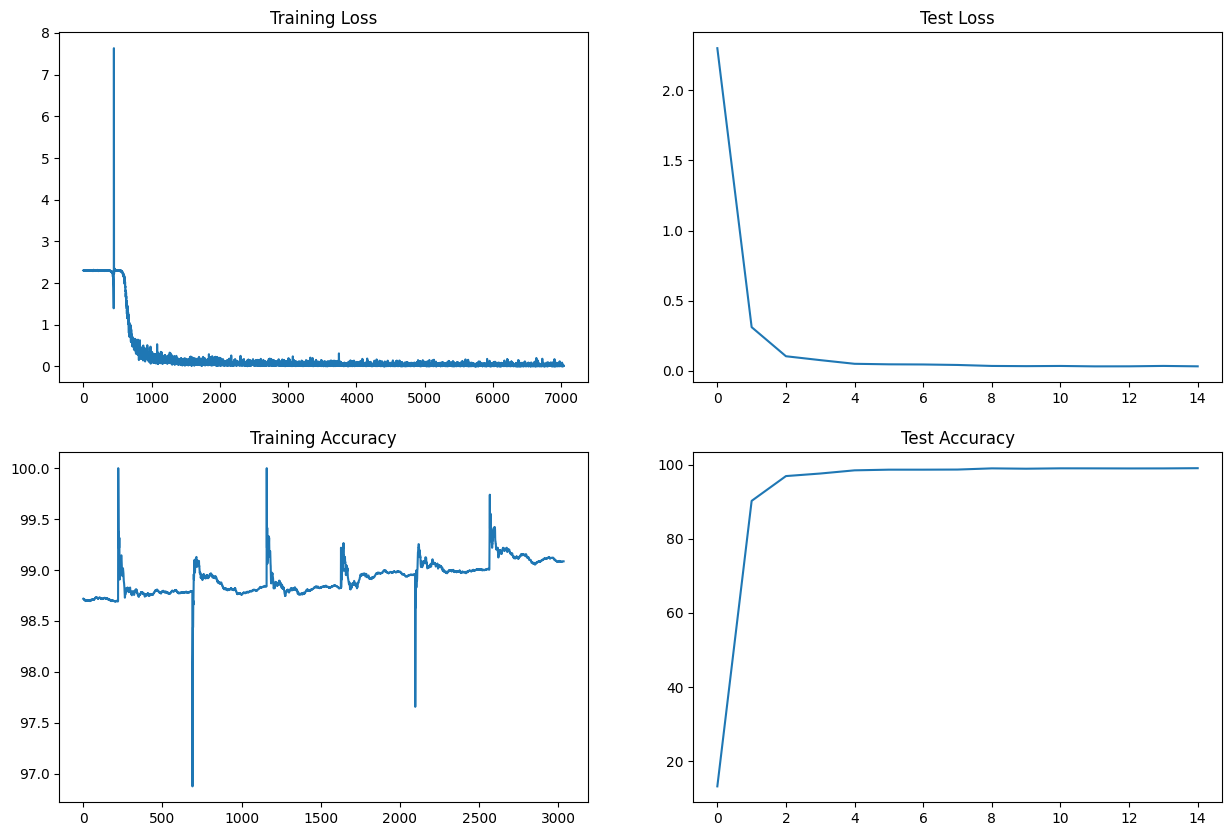

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [16]:
import pandas as pd

In [17]:
train_score= {'train_acc': train_acc , 'train_losses' : train_losses }
pd.DataFrame(train_score).describe()

,train_acc,train_losses
count,7035.000000,7035.000000
mean,87.903428,0.278367
std,26.738556,0.644489
min,6.250000,0.000720
25%,96.927005,0.024847
50%,98.524845,0.050937
75%,98.840479,0.107402
max,100.000000,7.634250


In [18]:
test_score = {'test_acc':test_acc,'test_losses':test_losses}
pd.DataFrame(test_score).describe()

,test_acc,test_losses
count,15.000000,15.000000
mean,92.355333,0.212334
std,22.017216,0.582435
min,13.180000,0.029888
25%,98.040000,0.032158
50%,98.680000,0.039950
75%,98.995000,0.061344
max,99.050000,2.301905
